In [2]:
import numpy as np, pandas as pd
from matplotlib.pyplot import subplots 
from sklearn.linear_model import \
(LinearRegression , LogisticRegression , Lasso)
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from ISLP import load_data
from ISLP.models import ModelSpec as MS 
from sklearn.model_selection import \
(train_test_split , GridSearchCV)

In [3]:
import torch

In [23]:
from torch import nn
from torch.optim import RMSprop
from torch.utils.data import TensorDataset
from torchmetrics import (MeanAbsoluteError , R2Score)
from torchinfo import summary

In [5]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger

In [6]:
from pytorch_lightning import seed_everything
seed_everything(0, workers=True)
torch.use_deterministic_algorithms(True, warn_only=True)

Global seed set to 0


In [7]:
from ISLP.torch import (SimpleDataModule,
                        SimpleModule,
                        ErrorTracker,
                        rec_num_workers)

In [8]:
from ISLP.torch.imdb import (load_lookup,
                             load_tensor,
                             load_sparse,
                             load_sequential)

This is a regression problem, where the goal is to predict the Salary of a baseball player in 1987 using his performance statistics from 1986. After removing players with missing responses, we are left with 263 players and 19 variables. We randomly split the data into a training set of 176 players (two thirds), and a test set of 87 players (one third). We used three methods for fitting a regression model to these data.

• A linear model was used to fit the training data, and make predictions on the test data. The model has 20 parameters.

• The same linear model was fit with lasso regularization. The tuning parameter was selected by 10-fold cross-validation on the training data. It selected a model with 12 variables having nonzero coefficients.

• A neural network with one hidden layer consisting of 64 ReLU units was fit to the data. This model has 1,345 parameters.

In [9]:
Hitters = load_data('Hitters').dropna()
n = Hitters.shape[0]

In [10]:
Hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


In [11]:
model = MS(Hitters.columns.drop('Salary'), intercept=False)
X = model.fit_transform(Hitters).to_numpy()
Y = Hitters['Salary'].to_numpy()

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=1/3, random_state=1)

#### Linear Model

In [13]:
hit_lm = LinearRegression().fit(X_train, Y_train)
Yhat_test = hit_lm.predict(X_test)
np.abs(Yhat_test - Y_test).mean() # mean absolute error

259.71528833146306

#### Lasso

In [14]:
scaler = StandardScaler(with_mean=True, with_std=True)
lasso = Lasso(warm_start=True, max_iter=30000)
standard_lasso = Pipeline(steps=[('scaler', scaler),
                                 ('lasso', lasso)])

In [15]:
X_s = scaler.fit_transform(X_train)
n = X_s.shape[0]
lam_max = np.fabs(X_s.T.dot(Y_train - Y_train.mean())).max() / n
param_grid = {'alpha': np.exp(np.linspace(0, np.log(0.01), 100)) # create a grid of values for alpha
             * lam_max}

In [16]:
cv = KFold(10,
           shuffle=True,
           random_state=1)
grid = GridSearchCV(lasso,
                    param_grid,
                    cv=cv,
                    scoring='neg_mean_absolute_error')
grid.fit(X_train, Y_train);

In [17]:
trained_lasso = grid.best_estimator_
Yhat_test = trained_lasso.predict(X_test)
np.fabs(Yhat_test - Y_test).mean()

257.2382010799502

#### Single Layer Network

In [18]:
class HittersModel(nn.Module):

    def __init__(self, input_size):
        super(HittersModel, self).__init__()
        self.flatten = nn.Flatten()
        self.sequential = nn.Sequential(
            nn.Linear(input_size, 50),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(50, 1))

    def forward(self, x):
        x = self.flatten(x)
        return torch.flatten(self.sequential(x))

In [19]:
X.shape

(263, 19)

In [20]:
hit_model = HittersModel(X.shape[1])

In [24]:
summary(hit_model, 
        input_size=X_train.shape,
        col_names=['input_size',
                   'output_size',
                   'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
HittersModel                             [175, 19]                 [175]                     --
├─Flatten: 1-1                           [175, 19]                 [175, 19]                 --
├─Sequential: 1-2                        [175, 19]                 [175, 1]                  --
│    └─Linear: 2-1                       [175, 19]                 [175, 50]                 1,000
│    └─ReLU: 2-2                         [175, 50]                 [175, 50]                 --
│    └─Dropout: 2-3                      [175, 50]                 [175, 50]                 --
│    └─Linear: 2-4                       [175, 50]                 [175, 1]                  51
Total params: 1,051
Trainable params: 1,051
Non-trainable params: 0
Total mult-adds (M): 0.18
Input size (MB): 0.01
Forward/backward pass size (MB): 0.07
Params size (MB): 0.00
Estimated Total Size (MB): 0.09

In [25]:
# transform data to datatype in torch: tensor
X_train_t = torch.tensor(X_train.astype(np.float32))
Y_train_t = torch.tensor(Y_train.astype(np.float32))
hit_train = TensorDataset(X_train_t, Y_train_t)
X_test_t = torch.tensor(X_test.astype(np.float32))
Y_test_t = torch.tensor(Y_test.astype(np.float32))
hit_test = TensorDataset(X_test_t, Y_test_t)

In [26]:
max_num_workers = rec_num_workers()
max_num_workers 

10

In [27]:
hit_dm = SimpleDataModule(hit_train,
                          hit_test,
                          batch_size=32,
                          num_workers=min(4, max_num_workers),
                          validation=hit_test)

In [28]:
hit_module = SimpleModule.regression(hit_model, metrics={'mae':MeanAbsoluteError()})

In [29]:
hit_logger = CSVLogger('logs', name='hitters')

In [30]:
hit_trainer = Trainer(deterministic=True,
                      max_epochs=50,
                      log_every_n_steps=5,
                      logger=hit_logger,
                      callbacks=[ErrorTracker()])
hit_trainer.fit(hit_module, datamodule=hit_dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type         | Params
---------------------------------------
0 | model | HittersModel | 1.1 K 
1 | loss  | MSELoss      | 0     
---------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


In [31]:
hit_trainer.test(hit_module, datamodule=hit_dm)

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │      104098.5703125       │
│         test_mae          │    229.50112915039062     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 104098.5703125, 'test_mae': 229.50112915039062}]

In [32]:
hit_results = pd.read_csv(hit_logger.experiment.metrics_file_path)

In [33]:
def summary_plot(results,
                 ax,
                 col='loss',
                 valid_legend='Validation',
                 training_legend='Training',
                 ylabel='Loss',
                 fontsize=20):
    for (column,
         color,
         label) in zip([f'train_{col}_epoch',
                        f'valid_{col}'],
                       ['black',
                        'red'],
                       [training_legend,
                        valid_legend]):
        results.plot(x='epoch',
                     y=column,
                     label=label,
                     marker='o',
                     color=color,
                     ax=ax)
    ax.set_xlabel('Epoch')
    ax.set_ylabel(ylabel)
    return ax

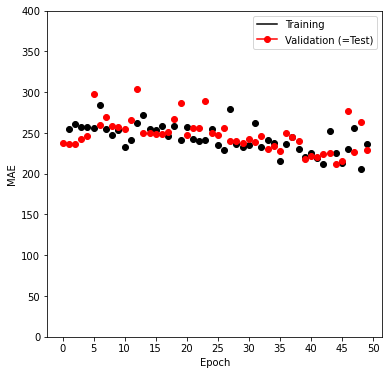

In [34]:
fig, ax = subplots(1, 1, figsize=(6, 6))
ax = summary_plot(hit_results,
                  ax,
                  col='mae',
                  ylabel='MAE',
                  valid_legend='Validation (=Test)')
ax.set_ylim([0, 400])
ax.set_xticks(np.linspace(0, 50, 11).astype(int));

In [35]:
hit_model.eval() 
preds = hit_module(X_test_t)
torch.abs(Y_test_t - preds).mean()

tensor(229.5011, grad_fn=<MeanBackward0>)

#### Clean Up

In [36]:
del(Hitters,
    hit_model, hit_dm,
    hit_logger,
    hit_test, hit_train,
    X, Y,
    X_test, X_train,
    Y_test, Y_train,
    X_test_t, Y_test_t,
    hit_trainer, hit_module)